In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops
from tensorflow.keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Task 1: Utilise Libraries/Dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#print(f"x_train: {x_train}")
print(f"y_train: {y_train}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)
y_train: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


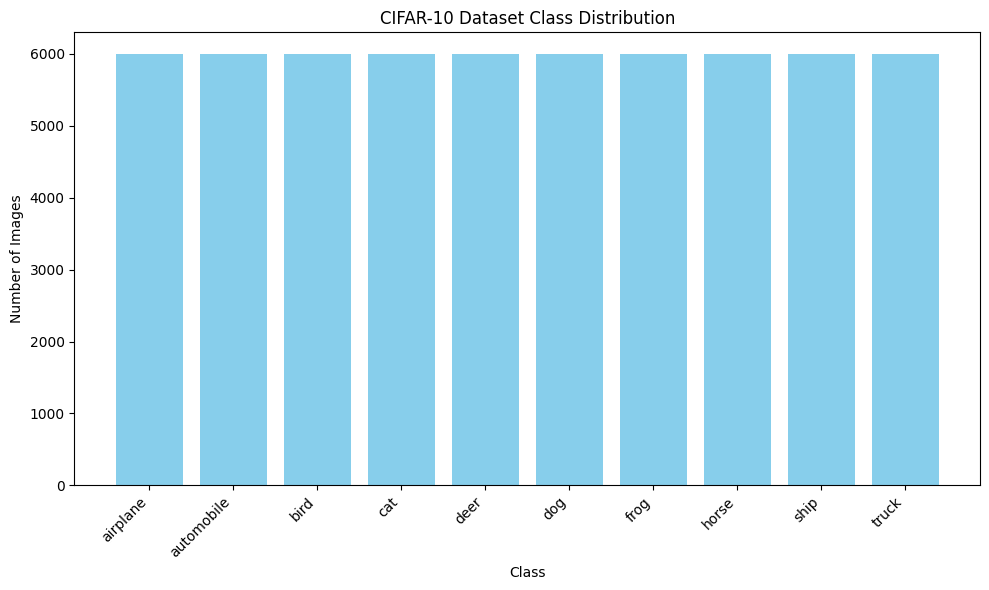

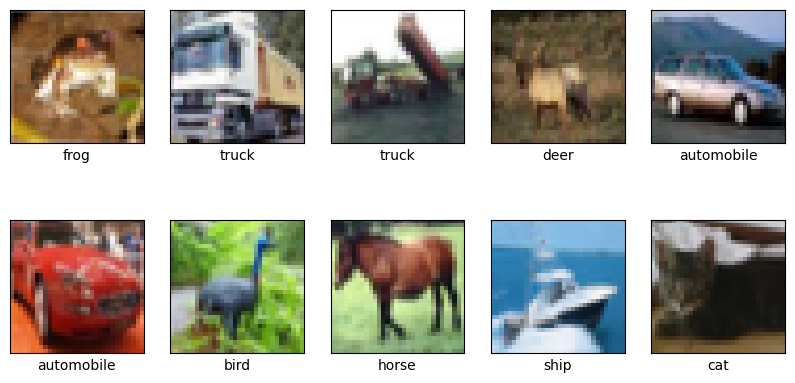

In [3]:
#Task 2: Generate at least two EDA visualisations

#Distribution by class
# Combine training and testing labels for the full dataset distribution
full_labels = np.concatenate((y_train, y_test), axis=0)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
unique_classes, counts = np.unique(full_labels, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('CIFAR-10 Dataset Class Distribution')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
#From the plot it appears that images are balanced in the dataset
#Print few images
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(labels[y_train[i][0]])
plt.show()


In [4]:
#Task 3: Analyse data quality

print(np.isnan(x_train).any())
print(np.isnan(x_test).any())

#!pip install cleanlab
#import torch
#import torchvision
#import timm
#from cleanlab.outlier import OutOfDistribution
#from cleanlab.rank import find_top_issues
# not checking for any outliers as cifr10 data is already clean


False
False


In [46]:
# Task 4: Construct a CNN model
num_classes = 10
input_shape = (32, 32, 3)
image_size = 72  # We'll resize input images to this size

data_augmentation = keras.Sequential(
     [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(12, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 3, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs)


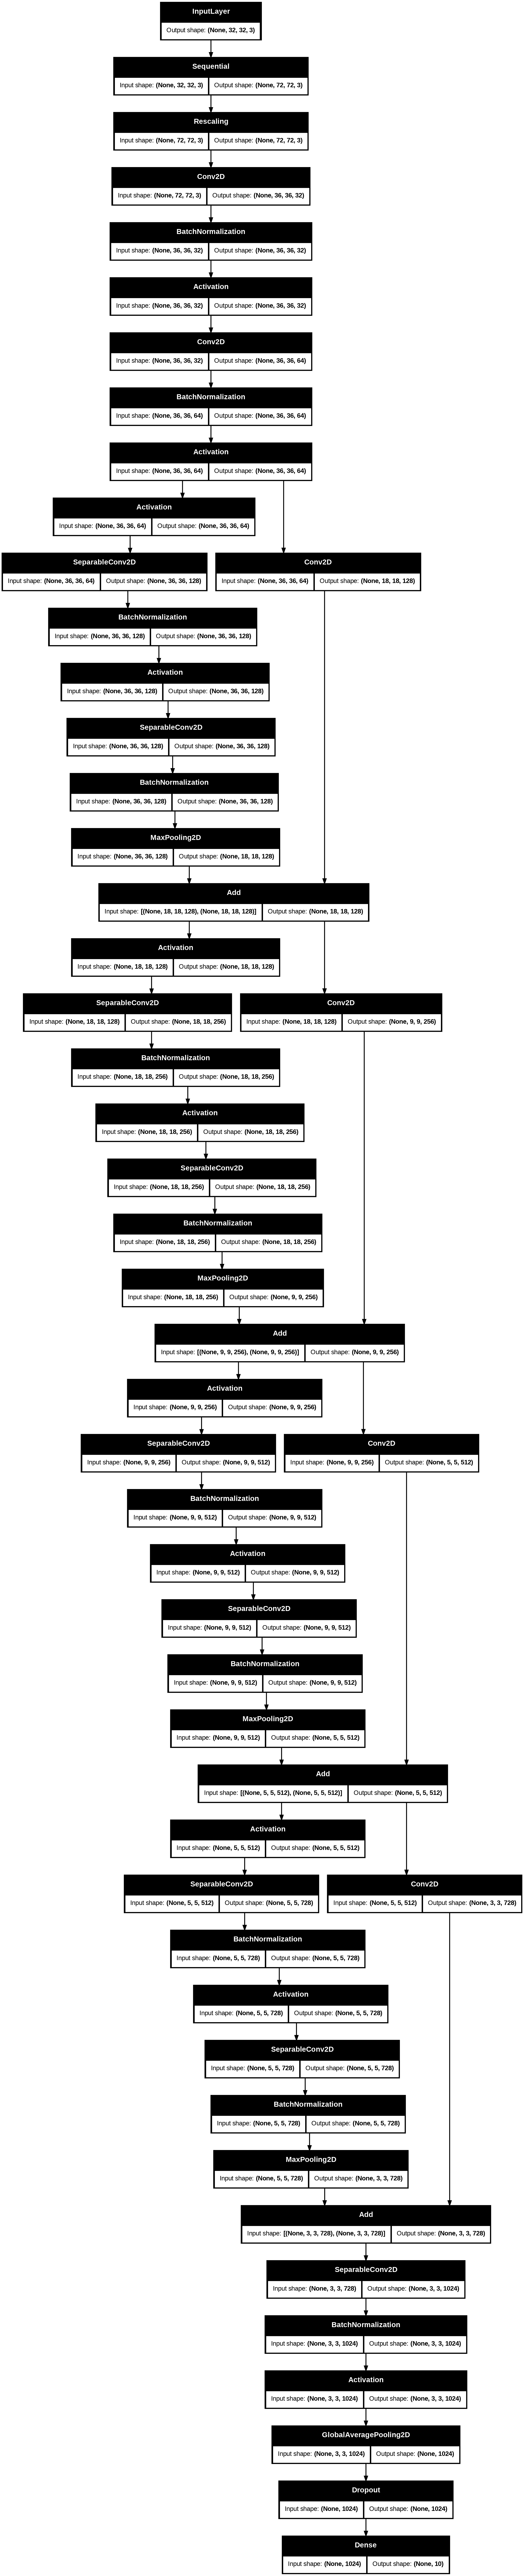

In [47]:
#Task 5: Train the CNN model using the CIFAR-10 dataset

model = make_model(input_shape=input_shape, num_classes=num_classes)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
#Task 6: Display model architecture and training progress
keras.utils.plot_model(model, show_shapes=True)



In [48]:
history_cnn = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 73ms/step - accuracy: 0.3520 - loss: 1.7939 - val_accuracy: 0.3855 - val_loss: 1.9921
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 92s 74ms/step - accuracy: 0.5806 - loss: 1.1740 - val_accuracy: 0.4439 - val_loss: 1.7467
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.6467 - loss: 0.9938 - val_accuracy: 0.5369 - val_loss: 1.5977
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.6921 - loss: 0.8825 - val_accuracy: 0.6654 - val_loss: 0.9971
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.7134 - loss: 0.8260 - val_accuracy: 0.6390 - val_loss: 1.1006
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.7359 - loss: 0.7641 - val_accuracy: 0.6899 - val_loss: 0.9344
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 93s 75ms/step - accuracy: 0.7493 - loss: 0.7229 - val_accuracy: 0.6779 - val_loss: 0.9507
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.7684 

In [49]:
#set hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier
checkpoint_filepath = "checkpoint.weights.h5"

In [50]:
#Implement multi layer perceptron
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [51]:
#Implement patch creation
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [52]:
#Implement patch encoder
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [53]:
#Task 7: Construct a ViT model

def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [54]:
def compile_model(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    return model, checkpoint_callback

model_vit = create_vit_classifier()
model_vit, checkpoint_callback = compile_model(model_vit)
#Task 9: Display model architecture and training progress
keras.utils.plot_model(model_vit, show_shapes=True)



In [56]:
#Task 8: Train the ViT model using the CIFAR-10 dataset
history_vit = model_vit.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )



Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 390ms/step - accuracy: 0.1521 - loss: 5.0953 - top-5-accuracy: 0.6215 - val_accuracy: 0.2398 - val_loss: 2.0068 - val_top-5-accuracy: 0.8002
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 72s 411ms/step - accuracy: 0.2197 - loss: 2.0656 - top-5-accuracy: 0.7574 - val_accuracy: 0.3410 - val_loss: 1.8273 - val_top-5-accuracy: 0.8452
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 419ms/step - accuracy: 0.2828 - loss: 1.9349 - top-5-accuracy: 0.8073 - val_accuracy: 0.3974 - val_loss: 1.7234 - val_top-5-accuracy: 0.8864
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 430ms/step - accuracy: 0.3304 - loss: 1.8131 - top-5-accuracy: 0.8458 - val_accuracy: 0.4388 - val_loss: 1.6256 - val_top-5-accuracy: 0.9024
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 419ms/step - accuracy: 0.3860 - loss: 1.6866 - top-5-accuracy: 0.8780 - val_accuracy: 0.4712 - val_loss: 1.6172 - val_top-5-accuracy: 0.9140
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 419ms/step - accuracy: 0.4132 -

In [57]:
def plotTrainingProcess(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(train_loss) + 1)

  # Plot the training and validation loss
  plt.figure(figsize=(18, 13))
  plt.plot(epochs, train_loss, 'g', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  #plot training and validation accuray
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(train_accuracy) + 1)

  # Plot the training and validation accuracy
  plt.figure(figsize=(18, 13))
  plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

CNN Model Training and Validatiom plot



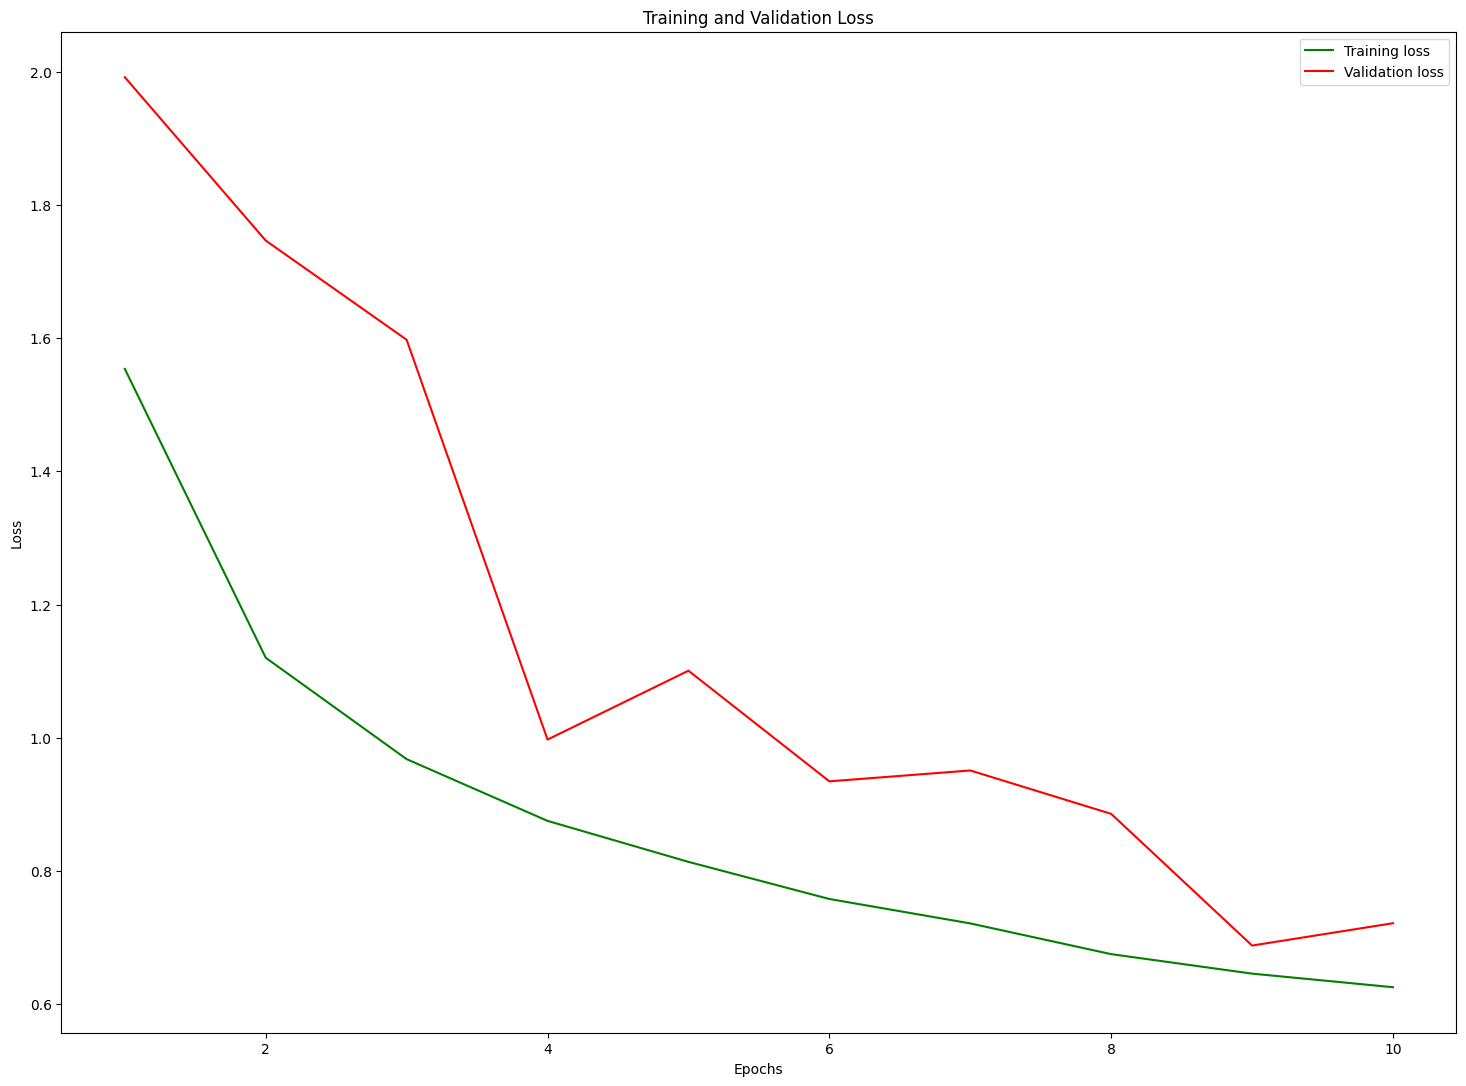

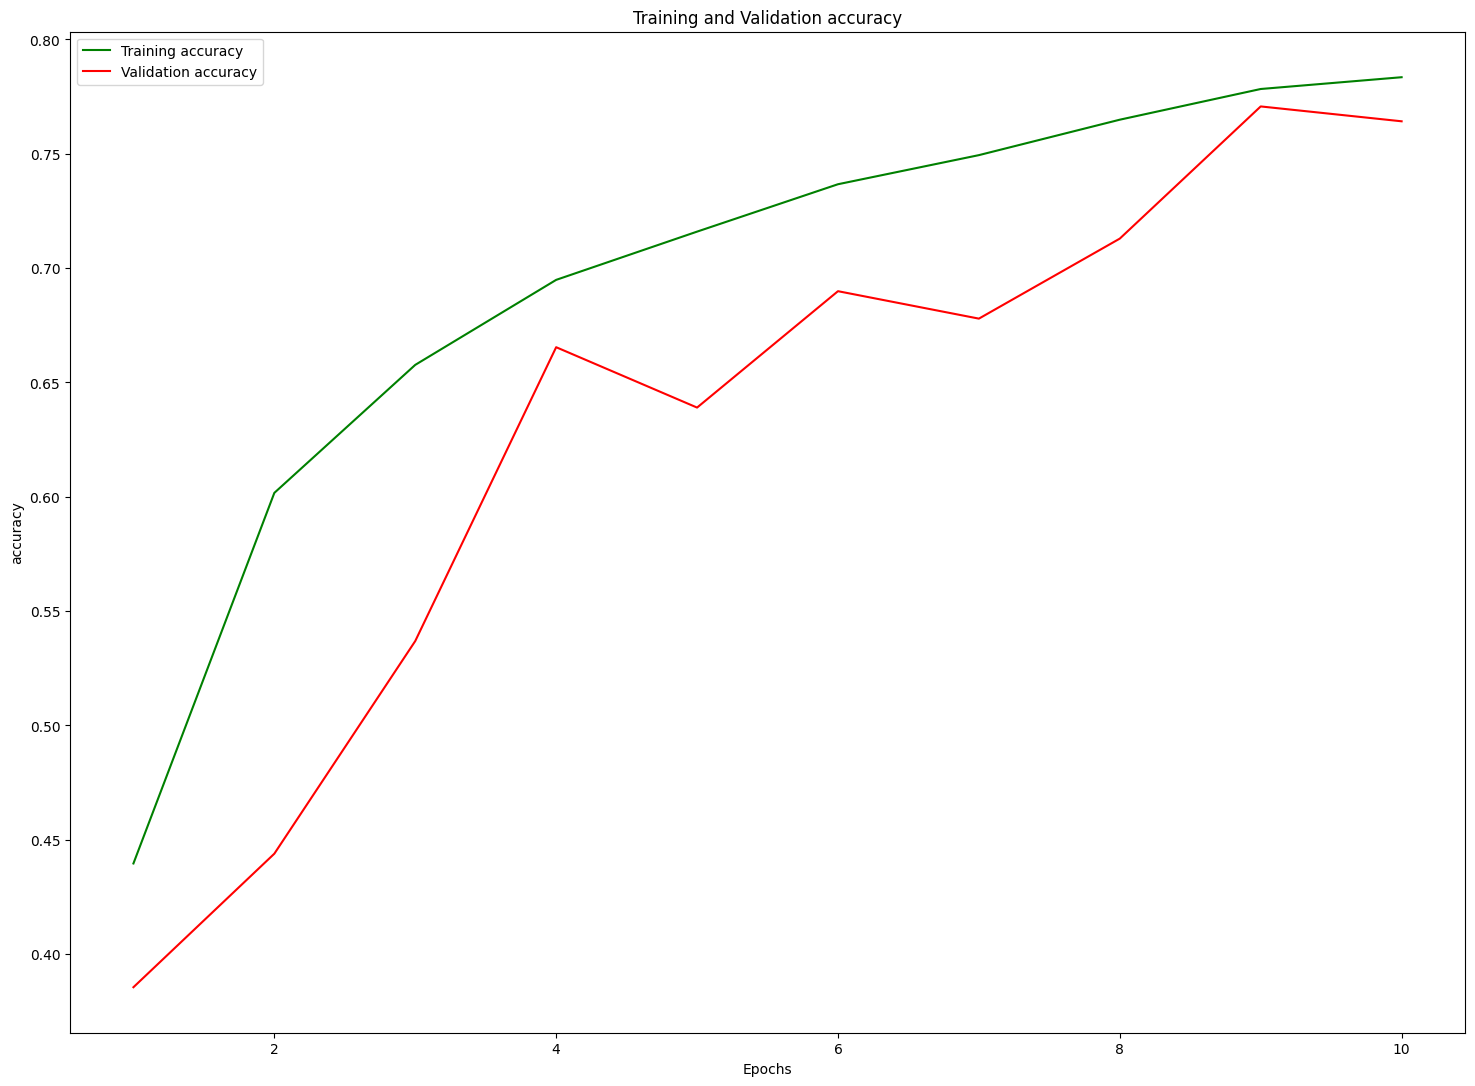

ViT Model Training and Validatiom plot



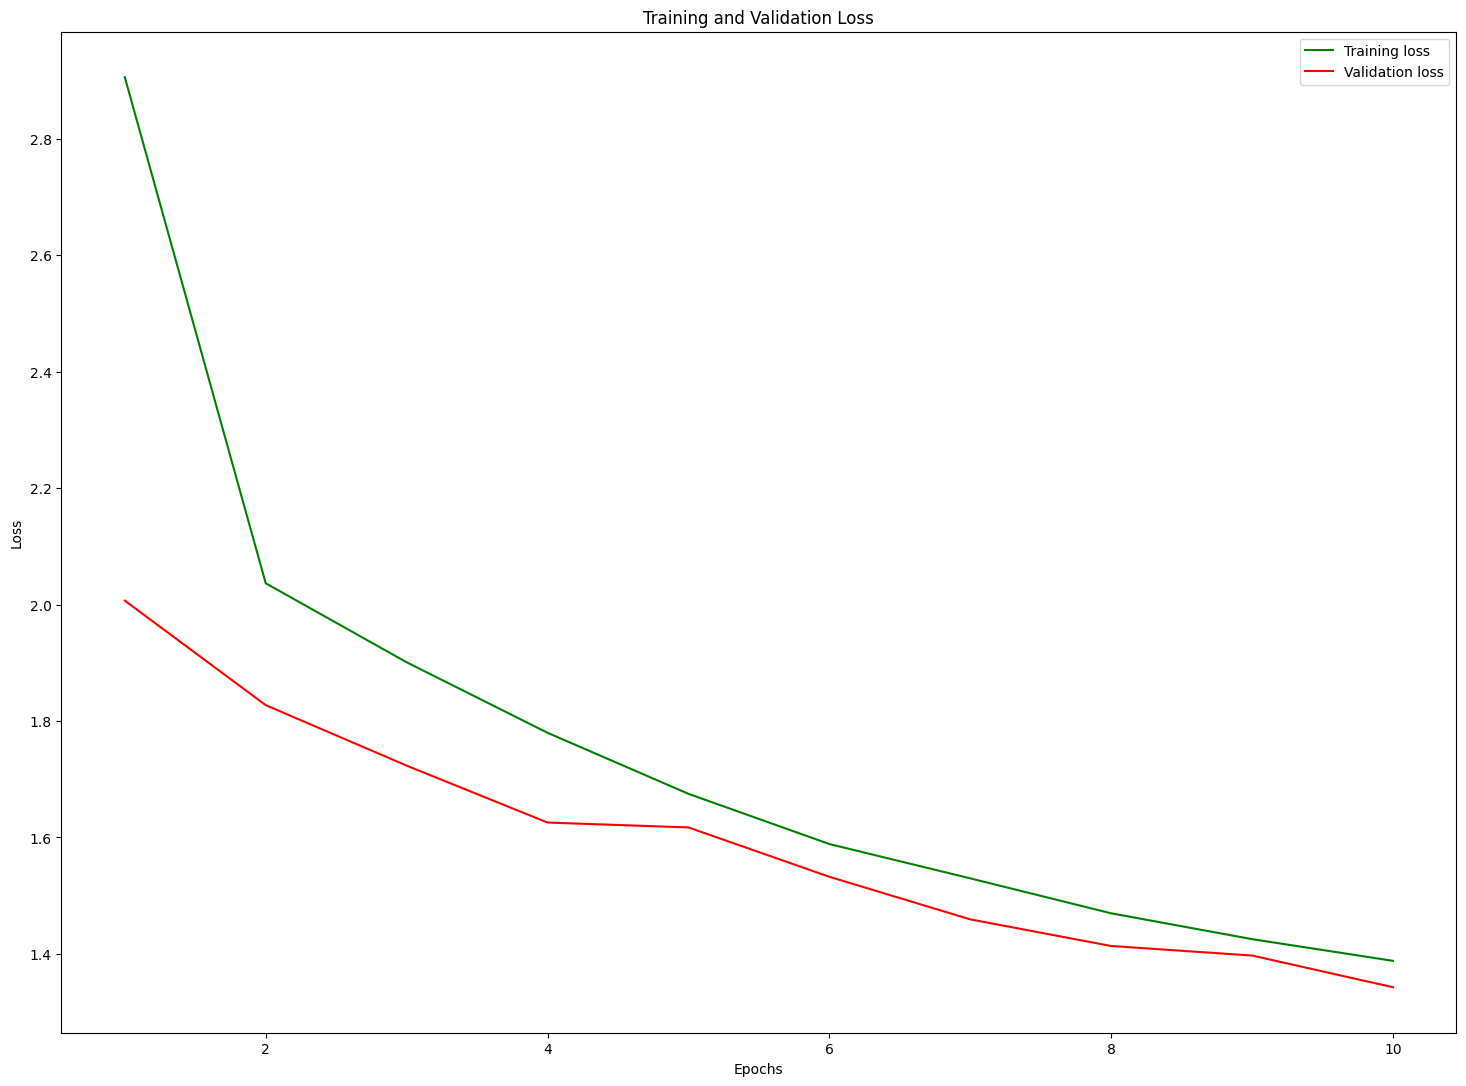

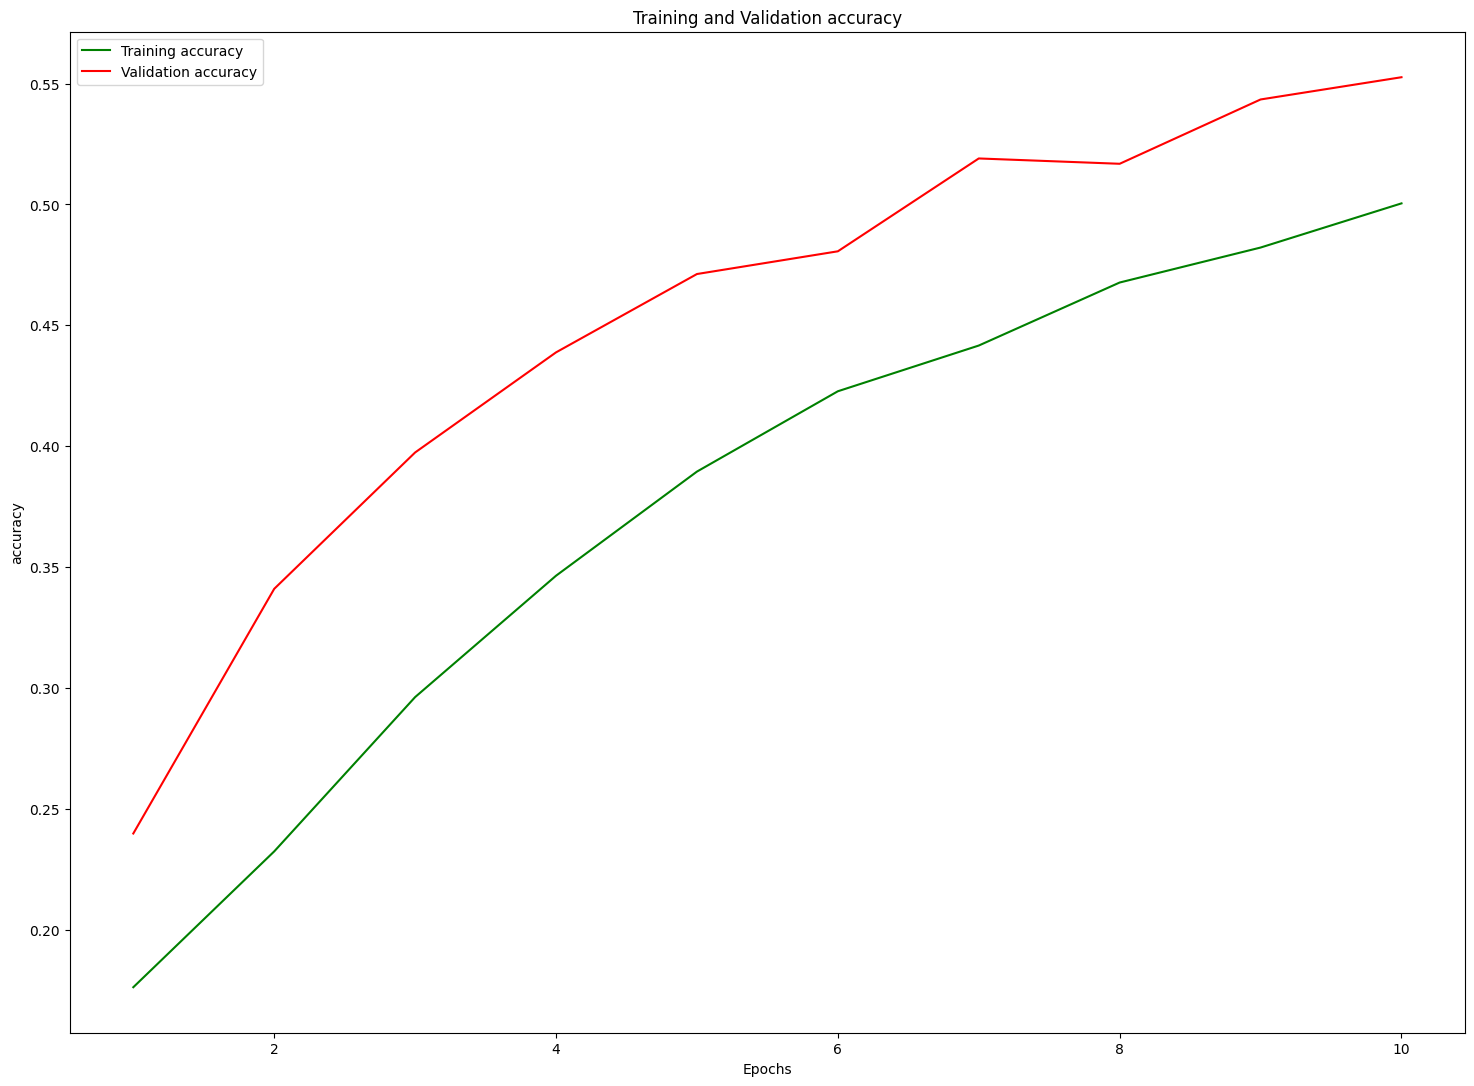

In [58]:
#Task 10: Compare training and validation results for each model:
print("CNN Model Training and Validatiom plot\n")
plotTrainingProcess(history_cnn)
print("ViT Model Training and Validatiom plot\n")
plotTrainingProcess(history_vit)